In [11]:
import SimpleITK as sitk
import tempfile
import os
import random
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

In [12]:
folder = f"{randint(1, 4)}"
files = os.listdir(f"../data/{folder}/")
random_file = random.choice(files)
random_file_w_path = f"../data/{folder}/{random_file}"
random_file_w_path

'../data/2/IE1705794_P406.i180100.raw'

In [13]:
good_image = '../data/1/IE1705794_P406.i180756.raw'
bad_image1 = '../data/4/IE1705794_P406.i180756.raw'
bad_image2 = '../data/2/IE1705794_P406.i180756.raw'

In [14]:
umin=137
umax=52578

In [15]:

def read_raw(
    binary_file_name,
    image_size,
    sitk_pixel_type = sitk.sitkUInt16,
    image_spacing=None,
    image_origin=None,
    big_endian=False,
):
    """
    Read a raw binary scalar image.

    Parameters
    ----------
    binary_file_name (str): Raw, binary image file content.
    image_size (tuple like): Size of image (e.g. [2048,2048])
    sitk_pixel_type (SimpleITK pixel type: Pixel type of data (e.g.
        sitk.sitkUInt16).
    image_spacing (tuple like): Optional image spacing, if none given assumed
        to be [1]*dim.
    image_origin (tuple like): Optional image origin, if none given assumed to
        be [0]*dim.
    big_endian (bool): Optional byte order indicator, if True big endian, else
        little endian.

    Returns
    -------
    SimpleITK image or None if fails.
    """

    pixel_dict = {
        sitk.sitkUInt8: "MET_UCHAR",
        sitk.sitkInt8: "MET_CHAR",
        sitk.sitkUInt16: "MET_USHORT",
        sitk.sitkInt16: "MET_SHORT",
        sitk.sitkUInt32: "MET_UINT",
        sitk.sitkInt32: "MET_INT",
        sitk.sitkUInt64: "MET_ULONG_LONG",
        sitk.sitkInt64: "MET_LONG_LONG",
        sitk.sitkFloat32: "MET_FLOAT",
        sitk.sitkFloat64: "MET_DOUBLE",
    }
    direction_cosine = [
        "1 0 0 1",
        "1 0 0 0 1 0 0 0 1",
        "1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1",
    ]
    dim = len(image_size)
    header = [
        "ObjectType = Image\n".encode(),
        (f"NDims = {dim}\n").encode(),
        ("DimSize = " + " ".join([str(v) for v in image_size]) + "\n").encode(),
        (
            "ElementSpacing = "
            + (
                " ".join([str(v) for v in image_spacing])
                if image_spacing
                else " ".join(["1"] * dim)
            )
            + "\n"
        ).encode(),
        (
            "Offset = "
            + (
                " ".join([str(v) for v in image_origin])
                if image_origin
                else " ".join(["0"] * dim) + "\n"
            )
        ).encode(),
        ("TransformMatrix = " + direction_cosine[dim - 2] + "\n").encode(),
        ("ElementType = " + pixel_dict[sitk_pixel_type] + "\n").encode(),
        "BinaryData = True\n".encode(),
        ("BinaryDataByteOrderMSB = " + str(big_endian) + "\n").encode(),
        # ElementDataFile must be the last entry in the header
        ("ElementDataFile = " + os.path.abspath(binary_file_name) + "\n").encode(),
    ]
    fp = tempfile.NamedTemporaryFile(suffix=".mhd", delete=False)

    # Not using the tempfile with a context manager and auto-delete
    # because on windows we can't open the file a second time for ReadImage.
    fp.writelines(header)
    fp.close()
    img = sitk.ReadImage(fp.name)
    os.remove(fp.name)
    return img




In [21]:
good_image_little = read_raw(
    binary_file_name=good_image,
    image_size=(400,400),
    big_endian=False,
)
good_image_big = read_raw(
    binary_file_name=good_image,
    image_size=(400,400),
    big_endian=True,
)
bad_image1_little = read_raw(
    binary_file_name=bad_image1,
    image_size=(400,400),
    big_endian=False,
)
bad_image1_big = read_raw(
    binary_file_name=bad_image1,
    image_size=(400,400),
    big_endian=True,
)
bad_image2_little = read_raw(
    binary_file_name=bad_image2,
    image_size=(400,400),
    big_endian=False,
)

bad_image2_big = read_raw(
    binary_file_name=bad_image2,
    image_size=(400,400),
    big_endian=True,
)

good_image_little = (np.array(sitk.GetArrayFromImage(good_image_little)) - umin)/(umax-umin)
good_image_big = (np.array(sitk.GetArrayFromImage(good_image_big)) - umin)/(umax-umin)

bad_image1_little = (np.array(sitk.GetArrayFromImage(bad_image1_little)) - umin)/(umax-umin)
bad_image1_big = (np.array(sitk.GetArrayFromImage(bad_image1_big))- umin)/(umax-umin)

bad_image2_little = (np.array(sitk.GetArrayFromImage(bad_image2_little)) - umin)/(umax-umin)
bad_image2_big = (np.array(sitk.GetArrayFromImage(bad_image2_big)) - umin)/(umax-umin)


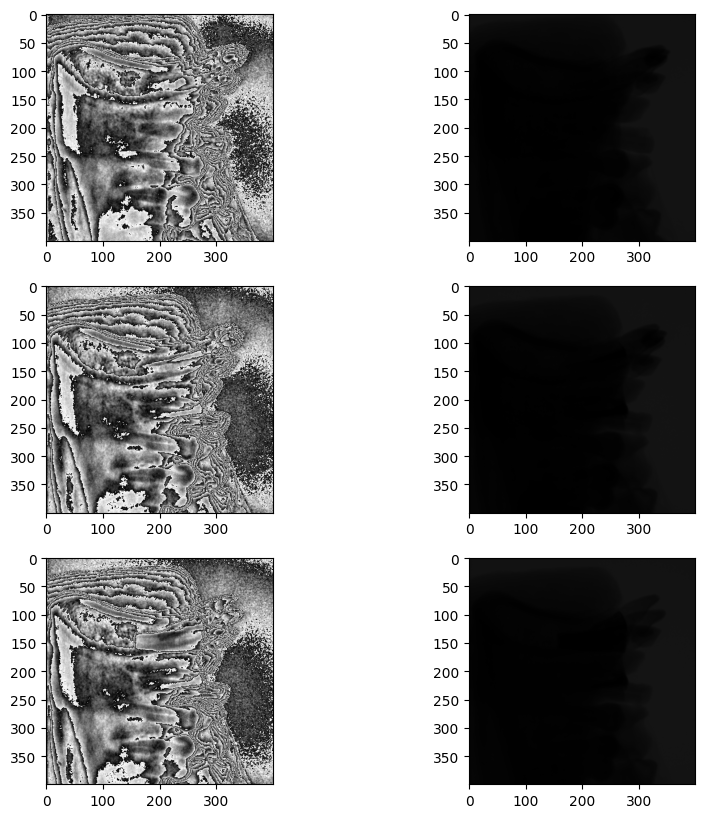

In [22]:

fig,(ax1,ax2,ax3) = plt.subplots(3,2,figsize=(10,10))
ax1[0].imshow(good_image_little, cmap='gray')
ax1[1].imshow(good_image_big,cmap='gray')
ax2[0].imshow(bad_image1_little, cmap='gray')
ax2[1].imshow(bad_image1_big, cmap='gray')
ax3[0].imshow(bad_image2_little, cmap='gray')
ax3[1].imshow(bad_image2_big, cmap='gray')



In [53]:
good_image_little.shape

(400, 400)

In [18]:
t = good_image_little = read_raw(
    binary_file_name=good_image,
    image_size=(400,400),
    big_endian=True,
)
def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    
    
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        """ if not c in (3,4):
            #raise Runtime("Unable to show 3D-vector Image") """
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
   
    
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [23]:
good_image_little.shape
plt.imsave('good_image_big.png', good_image_big, cmap='gray')

In [24]:
im = Image.open("good_image_big.png")
enhancer = ImageEnhance.Brightness(im)
im_output = enhancer.enhance(3)


In [25]:
np.array(im)[5]

array([[ 14,  14,  14, 255],
       [ 15,  15,  15, 255],
       [ 16,  16,  16, 255],
       ...,
       [ 17,  17,  17, 255],
       [ 17,  17,  17, 255],
       [ 17,  17,  17, 255]], dtype=uint8)

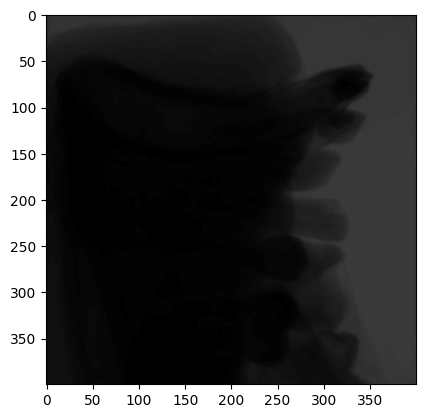

In [27]:
plt.imshow(im_output)

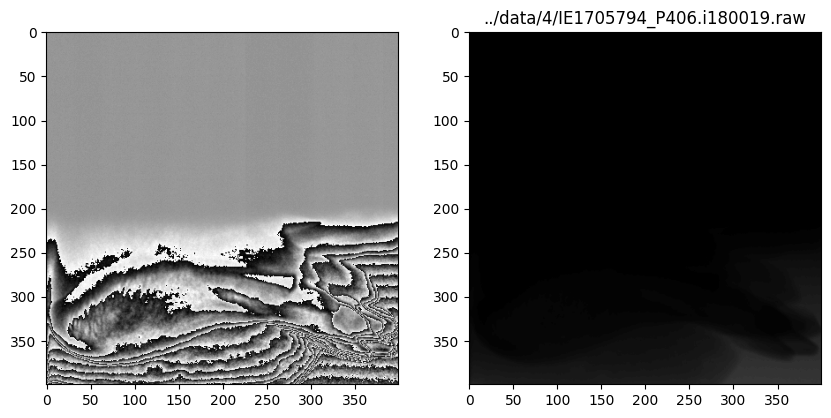

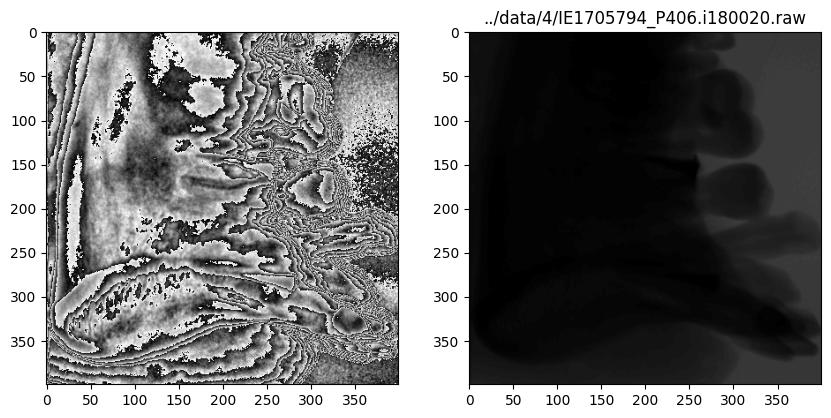

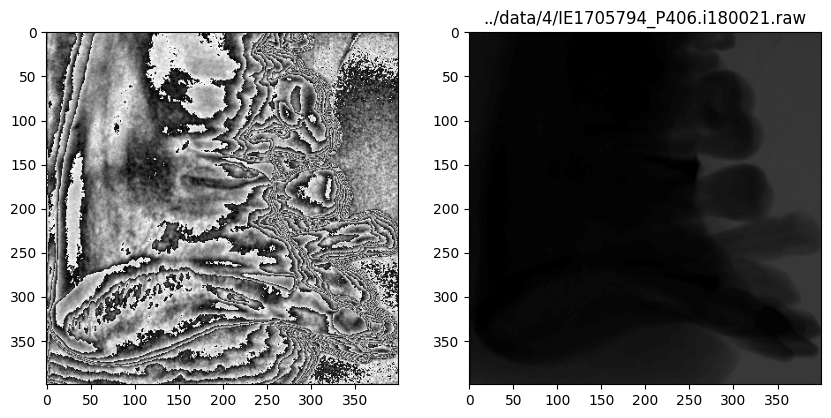

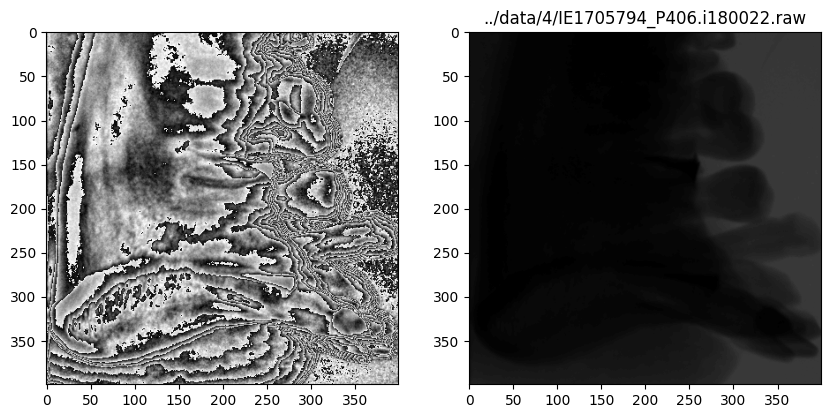

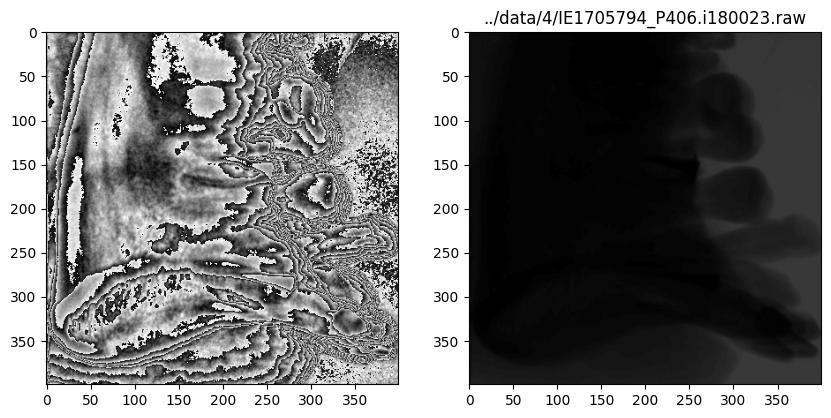

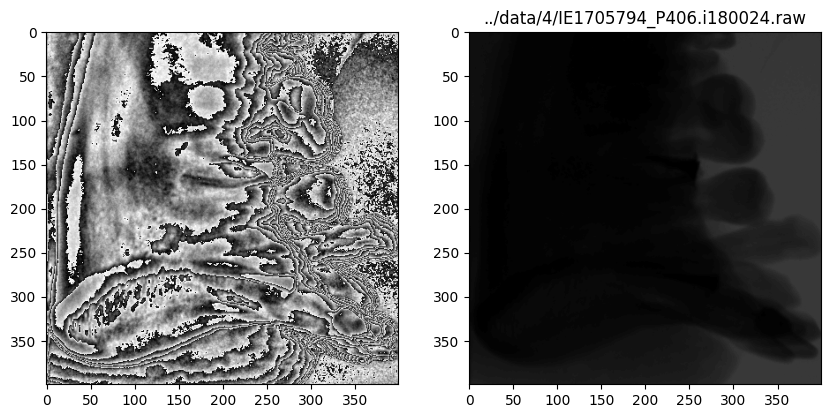

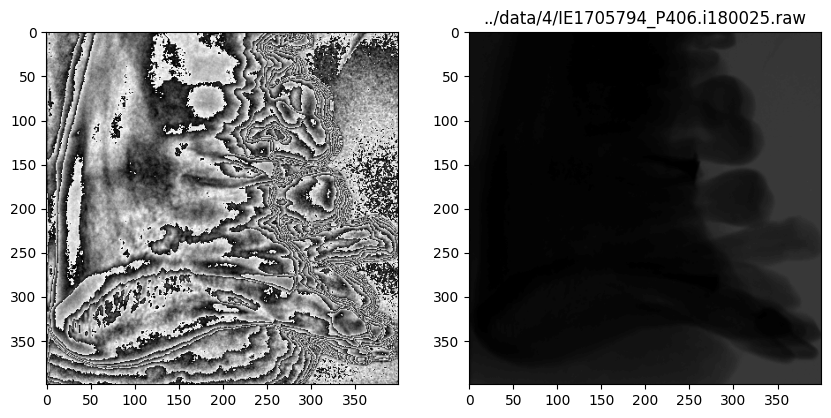

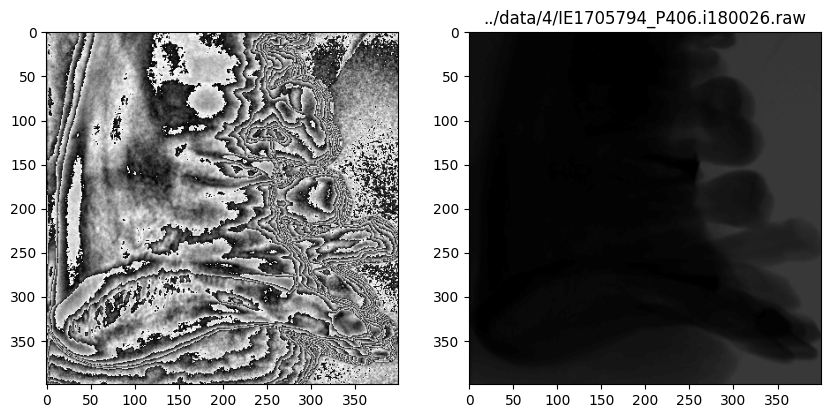

KeyboardInterrupt: 

In [73]:
folder = 4
files = os.listdir(f"../data/{folder}/")


for file in sorted(files):
    if file.endswith(".raw"):
        path = f"../data/{folder}/{file}"
        im1 = read_raw(path, image_size = (400,400), big_endian = False)
        im2 = read_raw(path, image_size = (400,400), big_endian = True)
        im1 = (np.array(sitk.GetArrayFromImage(im1)) - umin)/(umax-umin)
        im2 = Image.fromarray( ((np.array(sitk.GetArrayFromImage(im2)) - umin)/(umax-umin) * 255).astype(np.uint8)  )
        enhancer = ImageEnhance.Brightness(im2)
        im2 = enhancer.enhance(3)
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
        ax1.imshow(im1, cmap='gray')
        ax2.imshow(im2, cmap='gray')
        plt.title(path)
        plt.show()

#i1800018
